### Imports & load data

In [1]:
# Imports
import os 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist 
from sklearn.decomposition import PCA
import mglearn






# imports own modules
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab\Code\distinguish_pac')




C:\Users\jaapv\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\jaapv\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Set directory in which the data structure can be found
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')

# data
datastruct = np.load('data_dict.npy',  allow_pickle=True).item()
features_df = np.load('features_df.npy', allow_pickle=True).item()

### Desciptive statistics

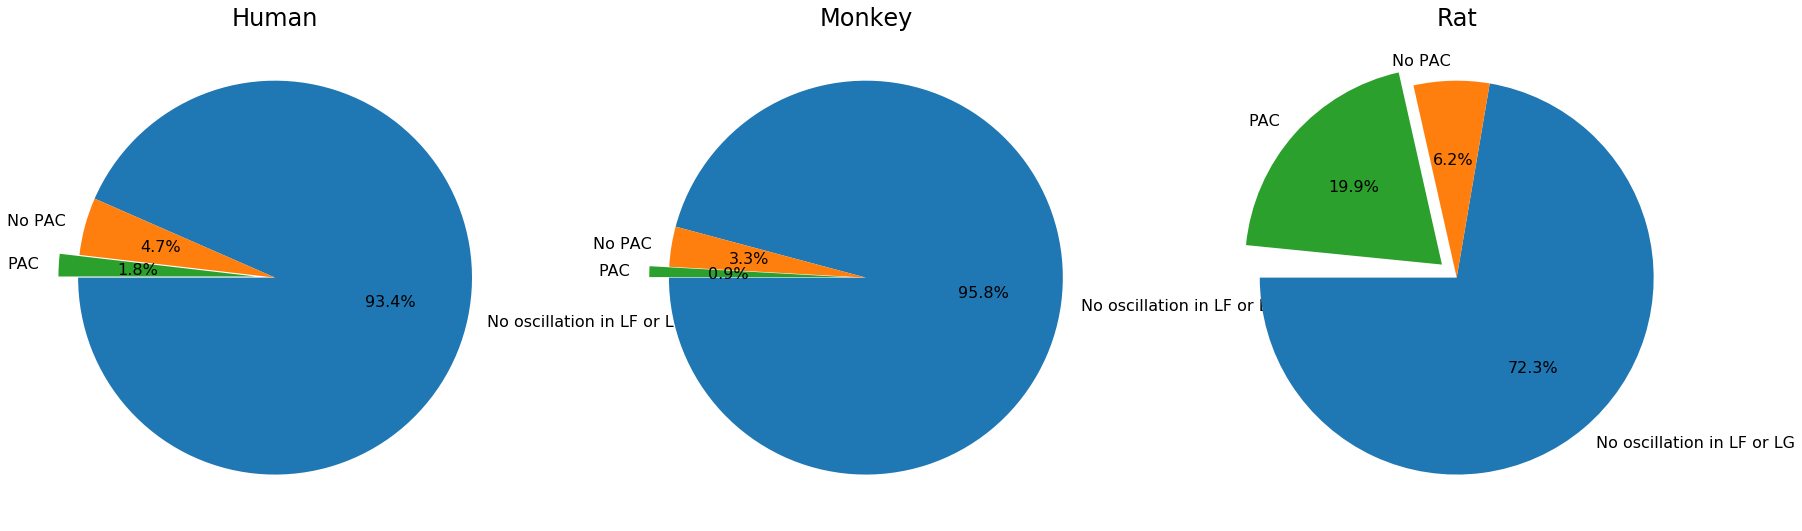

In [3]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'No oscillation in LF or LG', 'No PAC', 'PAC'
sizes = [[1 - (len(features_df['human'][(~np.isnan(features_df['human']['CF'])) &
                                         (~np.isnan(features_df['human']['LG_CF']))]) / len(features_df['human'])),
         len(features_df['human'][features_df['human']['LG_pac_presence']==0]) / len(features_df['human']),
         len(features_df['human'][features_df['human']['LG_pac_presence']==1]) / len(features_df['human'])],
         
         [1 - (len(features_df['monkey'][(~np.isnan(features_df['monkey']['CF'])) &
                                         (~np.isnan(features_df['monkey']['LG_CF']))]) / len(features_df['monkey'])),
         len(features_df['monkey'][features_df['monkey']['LG_pac_presence']==0]) / len(features_df['monkey']),
         len(features_df['monkey'][features_df['monkey']['LG_pac_presence']==1]) / len(features_df['monkey'])],

         [1 - (len(features_df['rat'][(~np.isnan(features_df['rat']['CF'])) &
                                      (~np.isnan(features_df['rat']['LG_CF']))]) / len(features_df['rat'])),
         len(features_df['rat'][features_df['rat']['LG_pac_presence']==0]) / len(features_df['rat']),
         len(features_df['rat'][features_df['rat']['LG_pac_presence']==1]) / len(features_df['rat'])]]
        
explode = (0, 0, 0.1)

titles = ['Human', 'Monkey', 'Rat']

plt.figure(figsize=(30,10))
for ii in range(len(sizes)): 

    # subplots 4x3
    plt.subplot(1,3,ii+1)
                
    plt.pie(sizes[ii], explode=explode, labels=labels, textprops={'size': 16}, autopct='%1.1f%%',
            shadow=False, startangle=180)
   # plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(titles[ii], size=24)


 <div class="alert alert-danger">
Only in rats we see a big percentage of channels with a oscillation between 30 and 58Hz, and also most of these channels show PAC. Other datasets do not have enough channels with low gamma PAC to investigate, so only continue with rat data
</div>

# Correlation Matrix

In [4]:
features_df['rat'].columns

Index(['subj', 'day', 'ch', 'ep', 'CF', 'Amp', 'BW', 'offset', 'knee', 'exp',
       'LG_CF', 'LG_Amp', 'LG_BW', 'pac_presence', 'pac_pvals', 'pac_rhos',
       'LG_pac_presence', 'LG_pac_pvals', 'LG_pac_rhos', 'volt_amp', 'rdsym',
       'ptsym'],
      dtype='object')

Text(0.5, 1, 'Average correlation between features across datasets')

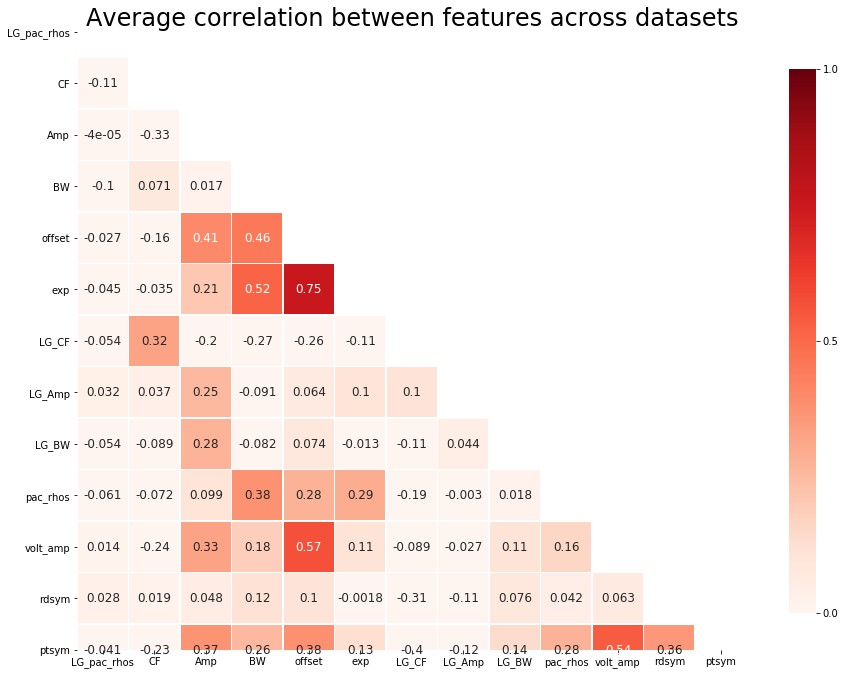

In [5]:
corr_mat_rat = features_df['rat'][['LG_pac_rhos',  'CF', 'Amp', 'BW', 'offset', 'exp',
       'LG_CF', 'LG_Amp', 'LG_BW', 'pac_rhos', 'volt_amp', 'rdsym', 'ptsym']].copy().corr()

mask = np.zeros_like(corr_mat_rat, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(15, 20))

heatmap = sns.heatmap(corr_mat_rat,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'Reds',
                      cbar_kws = {'shrink': .5,
                                'ticks' : [0, 0.5, 1]},
                      vmin = 0,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_mat_rat.columns, rotation = 0)
ax.set_xticklabels(corr_mat_rat.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
plt.title('Average correlation between features across datasets', size=24)

 <div class="alert alert-success">
High correlation between exp and offset, so combine these two features into 1. 
</div>

### Preprocessing and reshaping for ML

In [6]:
# change shape of the aperiodic slope measurement
offset = np.reshape(features_df['rat'][['offset']].copy(), [len(features_df['rat']['offset']), 1])
exp = np.reshape(features_df['rat'][['exp']].copy(), [len(features_df['rat']['exp']), 1])

# standard scale into 1 variable
scaler = StandardScaler()
slope = scaler.fit_transform(offset) + scaler.fit_transform(exp)

# write new feature to dataframe
features_df['rat']['slope'] = slope

In [7]:
# then only select the channels that have sig. PAC after resampling
features_df_pac = features_df['rat'][features_df['rat']['LG_pac_presence']==1]

In [8]:
# stack the PAC values, periodic features, and the waveform shape features into 1 SKLearn shape
cluster_features = np.hstack((
                   features_df_pac[['LG_pac_rhos']].copy(), features_df_pac[['CF']].copy(), 
                   features_df_pac[['Amp']].copy(), features_df_pac[['BW']].copy(), 
                   features_df_pac[['volt_amp']].copy(), features_df_pac[['rdsym']].copy(), 
                   features_df_pac[['ptsym']].copy(), features_df_pac[['LG_CF']].copy(),
                   features_df_pac[['LG_Amp']].copy(), features_df_pac[['LG_BW']].copy(),
                   features_df_pac[['slope']].copy()))

# Scale all data 
scaler = StandardScaler()
scaler.fit(cluster_features)
X_scaled = scaler.transform(cluster_features)

# Elbow method, PCA & Clustering

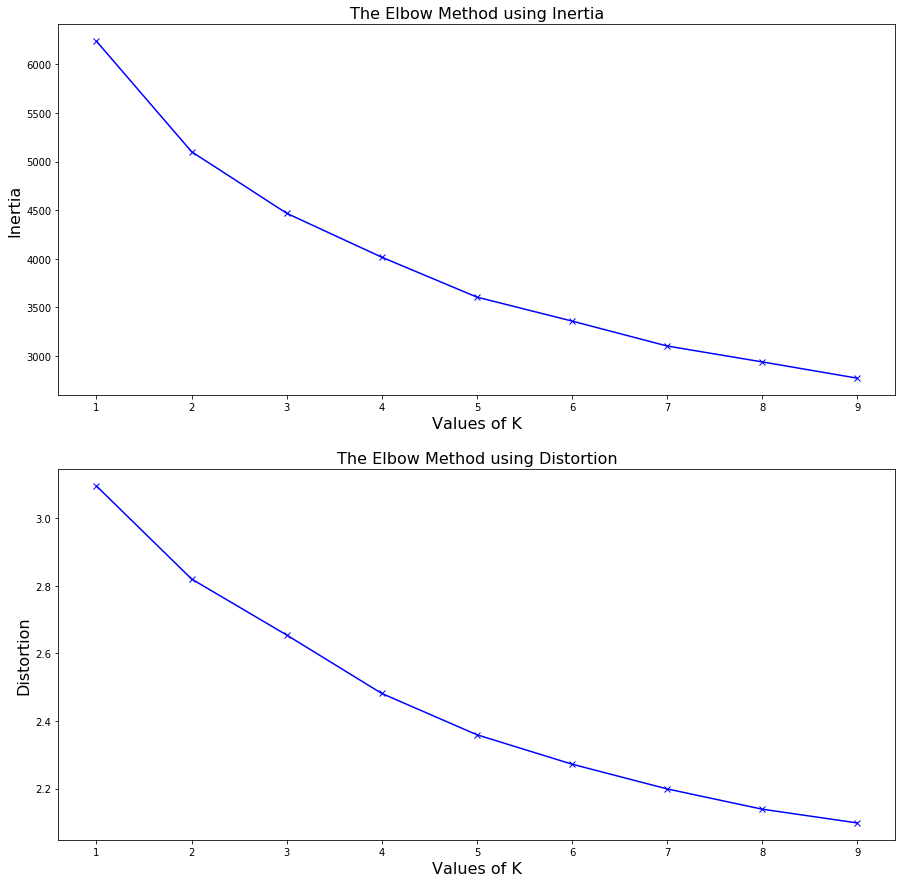

In [9]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X_scaled) 
    kmeanModel.fit(X_scaled)     
      
    distortions.append(sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K', size=16) 
plt.ylabel('Inertia', size=16) 
plt.title('The Elbow Method using Inertia', size=16) 

plt.subplot(2,1,2)
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K', size=16) 
plt.ylabel('Distortion', size=16) 
plt.title('The Elbow Method using Distortion', size=16) 
plt.show() 

In [10]:
# Use K-Means to cluster into two groups
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_scaled);

In [11]:
# Use PCA to create two components
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [12]:
# Create list with feature names for visualization 
feature_list = ['LG_pac_rhos', 'CF', 'Amp', 'BW', 'volt_amp', 'rdsym', 'ptsym', 
               'LG_CF', 'LG_Amp', 'LG_BW', 'slope' ]

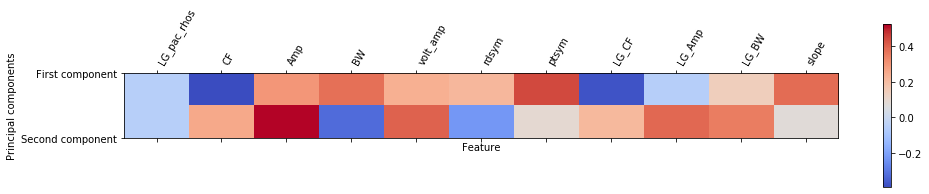

In [13]:
# Which features drive both components?
plt.matshow(pca.components_, cmap='coolwarm');
plt.yticks([0, 1], ["First component", "Second component"]);
plt.colorbar();
plt.xticks(range(len(feature_list)),feature_list, rotation=60, ha='left');
plt.xlabel("Feature");
plt.ylabel("Principal components");

Text(0, 0.5, 'Second principal component')

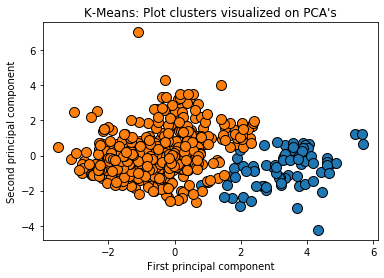

In [14]:
# visualize on PCA  
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:,1], kmeans.labels_, markers='o')
plt.title('K-Means: Plot clusters visualized on PCA\'s')
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

In [15]:
# write clusters to dataframe and merge with original one
features_df_pac['Clusters'] = kmeans.labels_

pd.options.mode.chained_assignment = None
features_df['rat'] = pd.merge(features_df['rat'], features_df_pac, how='outer')

C:\Users\jaapv\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
# add cluster number to the other groups as identification 
for ii in range(len(features_df['rat'])):
    
    # 11. no oscillations in either low frequency or low gamma range
    if (np.isnan(features_df['rat']['CF'][ii]) or np.isnan(features_df['rat']['LG_CF'][ii])):
        
        features_df['rat']['Clusters'][ii] = 11
    
    # 12. true oscillations but no sig. PAC
    if features_df['rat']['LG_pac_presence'][ii] == 0:
    
        features_df['rat']['Clusters'][ii] = 12


# Multiple Regression

In [17]:
X_features = ['CF', 'Amp', 'BW', 'volt_amp','rdsym', 'ptsym','LG_CF', 'LG_Amp','LG_BW', 'slope']

X_cluster0 = np.hstack((
    [features_df['rat'][features_df['rat']['Clusters'] == 0][[X_features[ii]]].copy() 
     for ii in range(len(X_features))]))

X_cluster1 = np.hstack((
    [features_df['rat'][features_df['rat']['Clusters'] == 1][[X_features[ii]]].copy() 
     for ii in range(len(X_features))]))

Y_cluster0 = features_df['rat'][features_df['rat']['Clusters'] == 0][['LG_pac_rhos']].copy()

Y_cluster1 = features_df['rat'][features_df['rat']['Clusters'] == 1][['LG_pac_rhos']].copy()

In [18]:
# fit and transform
X_cluster0 = scaler.fit(X_cluster0).transform(X_cluster0)
X_cluster1 = scaler.fit(X_cluster1).transform(X_cluster1)
Y_cluster0 = scaler.fit(Y_cluster0).transform(Y_cluster0)
Y_cluster1 = scaler.fit(Y_cluster1).transform(Y_cluster1)


# regression fit
reg_cluster0 = linear_model.LinearRegression().fit(X_cluster0, Y_cluster0)
reg_cluster1 = linear_model.LinearRegression().fit(X_cluster1, Y_cluster1)

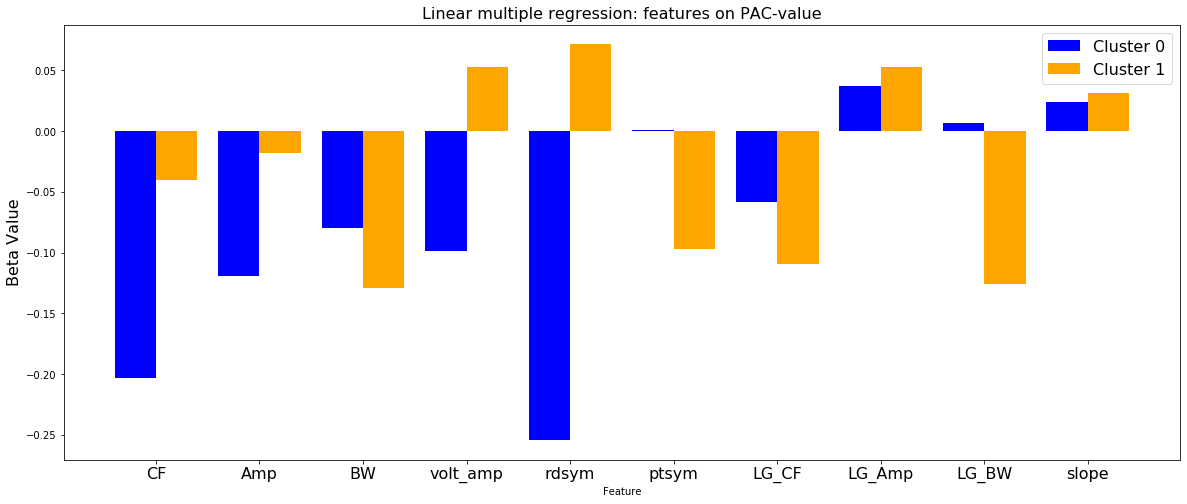

In [19]:
# Plot Beta values for the prediction of the PAC value for cluster 0, cluster 1, and the difference
plt.figure(figsize=(20,8))
index = np.arange(len(X_features))
bar_width = 0.4
opacity = 0.8

rects1 = plt.bar(index, reg_cluster0.coef_[0], bar_width,color='blue',label='Cluster 0')

rects2 = plt.bar(index + bar_width, reg_cluster1.coef_[0], bar_width,color='orange',label='Cluster 1')


plt.xlabel('Feature')
plt.ylabel('Beta Value',fontsize=16)
plt.title('Linear multiple regression: features on PAC-value',fontsize=16)
plt.xticks(index + (bar_width/2), X_features,fontsize=16)
plt.legend(fontsize=16)

# Distributions

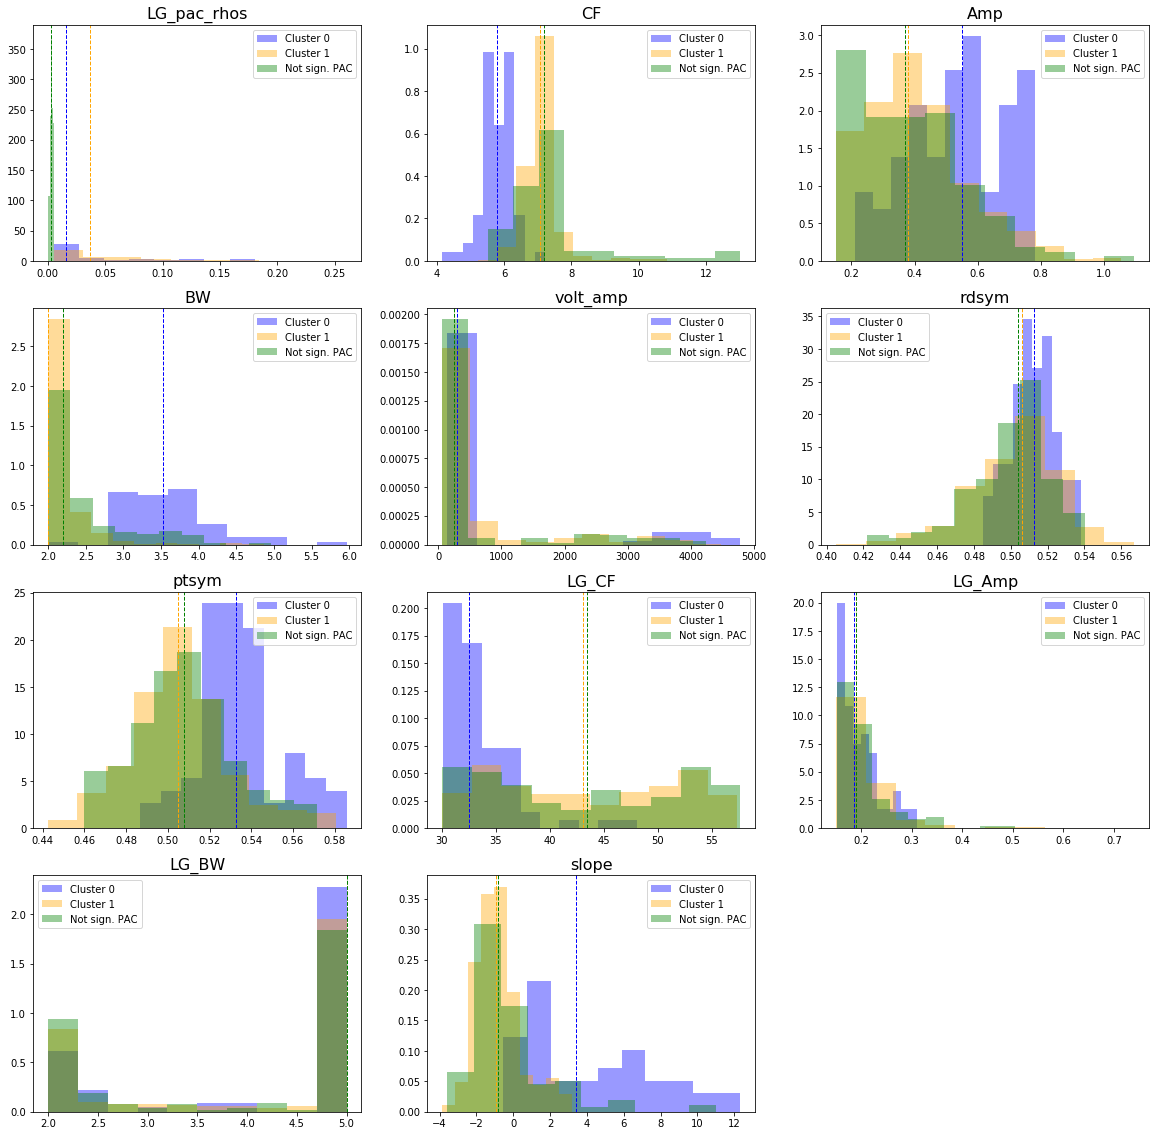

In [20]:
# manually set which columns you want to plot
#plot_list = [14,17,19,20,3,4,22,18,5] 


kwargs = dict(histtype='stepfilled', alpha=0.4, density=True, bins=10)

plt.figure(figsize=(20,20))
for ii in range(len(feature_list)): 
        
    # subplots 3x3
    plt.subplot(4,3,ii+1)
    #xticks([]), yticks([])
    
    plt.hist(features_df['rat'][features_df['rat']['Clusters']==0][feature_list[ii]], 
             color='blue', label= 'Cluster 0', **kwargs)
    plt.hist(features_df['rat'][features_df['rat']['Clusters']==1][feature_list[ii]], 
             color='orange', label= 'Cluster 1', **kwargs)
    plt.hist(features_df['rat'][features_df['rat']['Clusters']==12][feature_list[ii]], 
             color='green', label= 'Not sign. PAC', **kwargs)

    
    plt.axvline(np.median(features_df['rat'][features_df['rat']['Clusters']==0][feature_list[ii]]), 
                color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(np.median(features_df['rat'][features_df['rat']['Clusters']==1][feature_list[ii]]), 
                color='orange', linestyle='dashed', linewidth=1)
    plt.axvline(np.median(features_df['rat'][features_df['rat']['Clusters']==12][feature_list[ii]]), 
                color='green', linestyle='dashed', linewidth=1)
    
    # print statistics
    #stats = f_oneway(features_df[features_df['Clusters']==0][features_df.columns[jj]],
    #        features_df[features_df['Clusters']==1][features_df.columns[jj]], 
    #        features_df[features_df['Clusters']==12][features_df.columns[jj]]) 
    
    # plt.title(features_df.columns[jj] + '  ' + 'pval = ' + str(stats[1]), size=16)
    plt.title(feature_list[ii], size=16)
    plt.legend()

 <div class="alert alert-danger">
I dont think we can say much about the multiple regression and the clustering. There are no big differences and the clustering does not seem to work. Tried it with other features as well (such as excluding the low frequency CF, Amp, and BW, but this made the clusters even more close to each other. 
</div>

# Linear Regressions on Rho values

### Symmetry measures

In [21]:
# reshape pac_rhos
LG_pac_rhos_rat = features_df['rat'][features_df['rat']['LG_pac_presence']==1]['LG_pac_rhos'].values.reshape(-1,1)
HG_pac_rhos_rat = features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'].values.reshape(-1,1)

"""
The features/columns: 

['subj', 'day', 'ch', 'ep', 'CF', 'Amp', 'BW', 'offset', 'knee', 'exp',
       'LG_CF', 'LG_Amp', 'LG_BW', 'pac_presence', 'pac_pvals', 'pac_rhos',
       'LG_pac_presence', 'LG_pac_pvals', 'LG_pac_rhos', 'volt_amp', 'rdsym',
       'ptsym', 'slope', 'Clusters']
"""

feature = 'ptsym'

# reshape other feature
LG_feature_rat = abs(features_df['rat'][features_df['rat']['LG_pac_presence']==1][feature] -.5).values.reshape(-1,1)
HG_feature_rat = abs(features_df['rat'][features_df['rat']['pac_presence']==1][feature] -.5).values.reshape(-1,1)

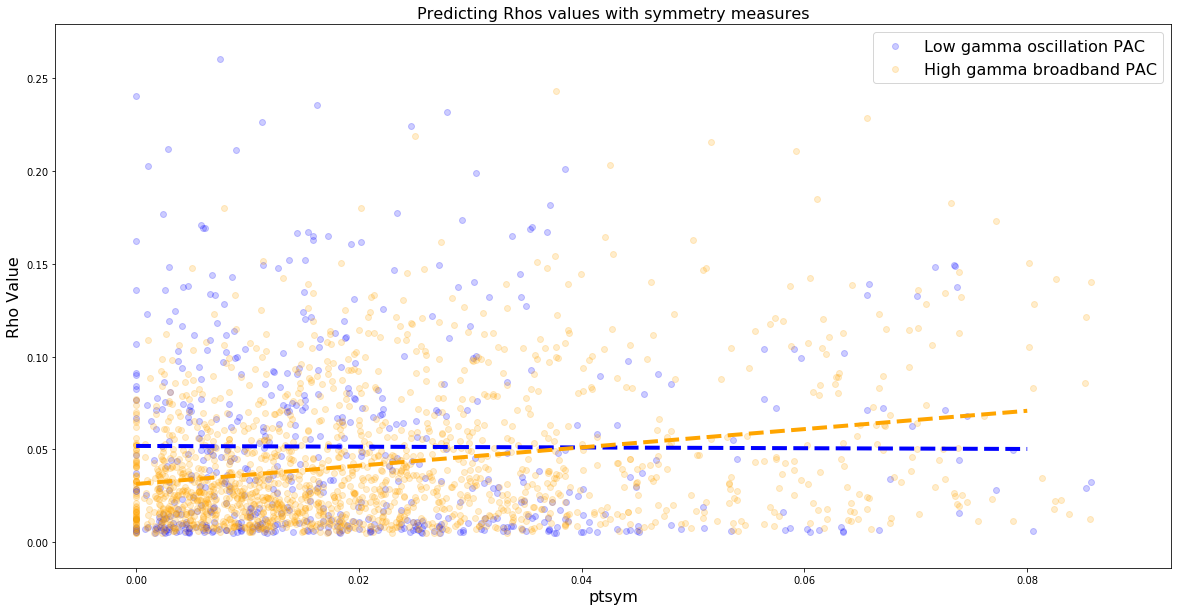

In [22]:
plt.figure(figsize=(20,10))

# Rat LG scatter
plt.scatter(abs(features_df['rat'][features_df['rat']['LG_pac_presence']==1][feature] - 0.5),
            features_df['rat'][features_df['rat']['LG_pac_presence']==1]['LG_pac_rhos'],
           color='blue', alpha =.2, label='Low gamma oscillation PAC')

# Rat HG scatter
plt.scatter(abs(features_df['rat'][features_df['rat']['pac_presence']==1][feature] - 0.5),
            features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'],
           color='orange', alpha =.2, label='High gamma broadband PAC')

# Rat regression
reg1 = linear_model.LinearRegression()
reg1.fit(LG_feature_rat, LG_pac_rhos_rat)
xs = np.arange(min(LG_feature_rat), max(LG_feature_rat),0.01)
ys = reg1.intercept_[0] + reg1.coef_[0][0] * xs
plt.plot(xs, ys, '--', color='blue', linewidth=4, alpha=1)

# Rat regression
reg2 = linear_model.LinearRegression()
reg2.fit(HG_feature_rat, HG_pac_rhos_rat)
xs = np.arange(min(HG_feature_rat), max(HG_feature_rat),0.01)
ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
plt.plot(xs, ys, '--', color='orange', linewidth=4, alpha=1)

# 
plt.title('Predicting Rhos values with symmetry measures', fontsize=16)
plt.xlabel(feature, fontsize=16)
plt.ylabel('Rho Value', fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Other features

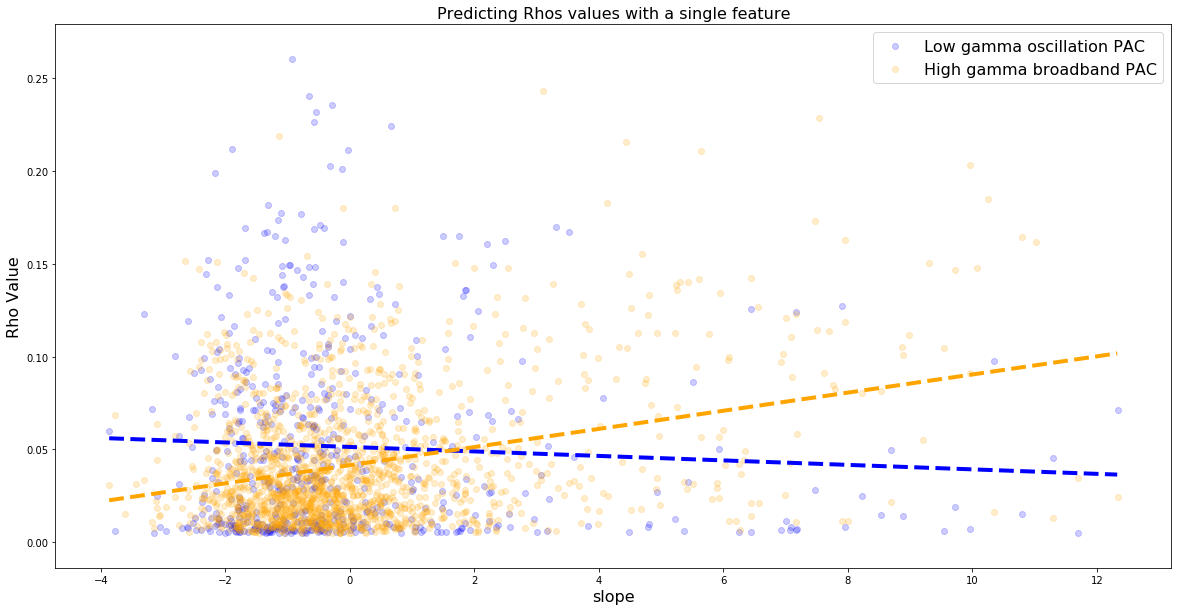

In [23]:
# reshape pac_rhos
LG_pac_rhos_rat = features_df['rat'][features_df['rat']['LG_pac_presence']==1]['LG_pac_rhos'].values.reshape(-1,1)
HG_pac_rhos_rat = features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'].values.reshape(-1,1)

"""
The features/columns: 

['subj', 'day', 'ch', 'ep', 'CF', 'Amp', 'BW', 'offset', 'knee', 'exp',
       'LG_CF', 'LG_Amp', 'LG_BW', 'pac_presence', 'pac_pvals', 'pac_rhos',
       'LG_pac_presence', 'LG_pac_pvals', 'LG_pac_rhos', 'volt_amp', 'rdsym',
       'ptsym', 'slope', 'Clusters']
"""

feature = 'slope'

# reshape other feature
LG_feature_rat = features_df['rat'][features_df['rat']['LG_pac_presence']==1][feature].values.reshape(-1,1)
HG_feature_rat = features_df['rat'][features_df['rat']['pac_presence']==1][feature].values.reshape(-1,1)

plt.figure(figsize=(20,10))

# Rat LG scatter
plt.scatter(features_df['rat'][features_df['rat']['LG_pac_presence']==1][feature],
            features_df['rat'][features_df['rat']['LG_pac_presence']==1]['LG_pac_rhos'],
           color='blue', alpha =.2, label='Low gamma oscillation PAC')

# Rat HG scatter
plt.scatter(features_df['rat'][features_df['rat']['pac_presence']==1][feature],
            features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'],
           color='orange', alpha =.2, label='High gamma broadband PAC')

# Rat regression
reg1 = linear_model.LinearRegression()
reg1.fit(LG_feature_rat, LG_pac_rhos_rat)
xs = np.arange(min(LG_feature_rat), max(LG_feature_rat),0.01)
ys = reg1.intercept_[0] + reg1.coef_[0][0] * xs
plt.plot(xs, ys, '--', color='blue', linewidth=4, alpha=1)

# Rat regression
reg2 = linear_model.LinearRegression()
reg2.fit(HG_feature_rat, HG_pac_rhos_rat)
xs = np.arange(min(HG_feature_rat), max(HG_feature_rat),0.01)
ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
plt.plot(xs, ys, '--', color='orange', linewidth=4, alpha=1)

# 
plt.title('Predicting Rhos values with a single feature', fontsize=16)
plt.xlabel(feature, fontsize=16)
plt.ylabel('Rho Value', fontsize=16)
plt.legend(fontsize=16)
plt.show()

# Comparing Rat data to ECoG (human & monkey) data

In [24]:
# change shape of the aperiodic slope measurement
offset = np.reshape(features_df['human'][['offset']].copy(), [len(features_df['human']['offset']), 1])
exp = np.reshape(features_df['human'][['exp']].copy(), [len(features_df['human']['exp']), 1])

# standard scale into 1 variable
scaler = StandardScaler()
slope = scaler.fit_transform(offset) + scaler.fit_transform(exp)

# write new feature to dataframe
features_df['human']['slope'] = slope

# repeat for monkey
# change shape of the aperiodic slope measurement
offset = np.reshape(features_df['monkey'][['offset']].copy(), [len(features_df['monkey']['offset']), 1])
exp = np.reshape(features_df['monkey'][['exp']].copy(), [len(features_df['monkey']['exp']), 1])

# standard scale into 1 variable
scaler = StandardScaler()
slope = scaler.fit_transform(offset) + scaler.fit_transform(exp)

# write new feature to dataframe
features_df['monkey']['slope'] = slope


### for symmetry measures

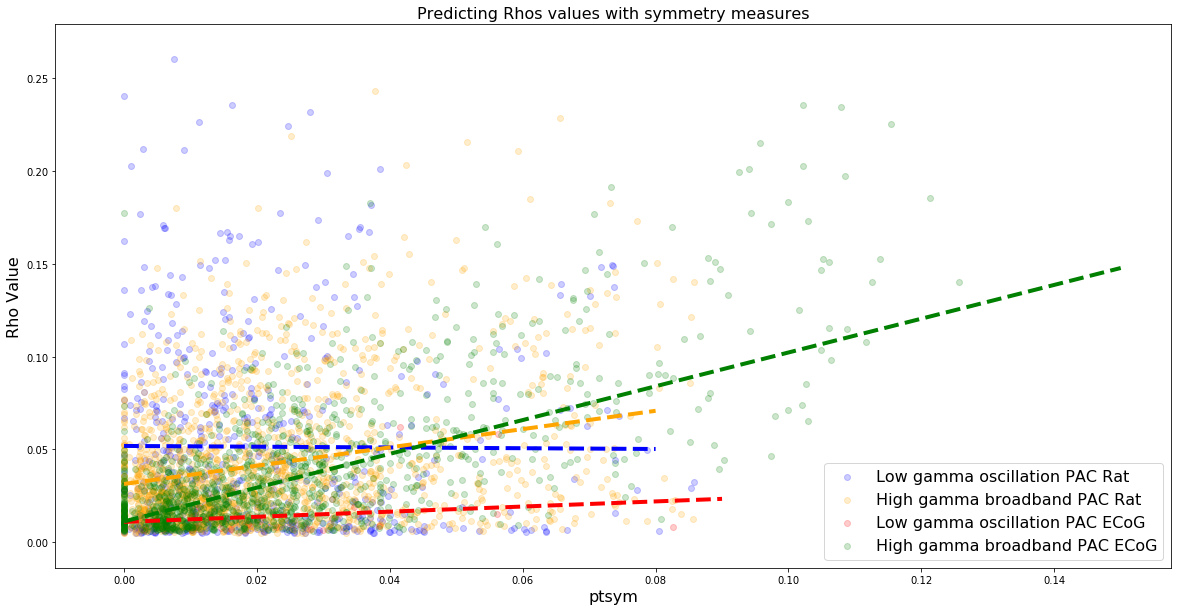

In [25]:
# reshape pac_rhos
LG_pac_rhos_rat = features_df['rat'][features_df['rat']['LG_pac_presence']==1]['LG_pac_rhos'].values.reshape(-1,1)
HG_pac_rhos_rat = features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'].values.reshape(-1,1)

LG_pac_rhos_ecog = np.append(features_df['monkey'][features_df['monkey']['LG_pac_presence']==1]['LG_pac_rhos'].values, 
         features_df['human'][features_df['human']['LG_pac_presence']==1]['LG_pac_rhos'].values).reshape(-1,1)
HG_pac_rhos_ecog = np.append(features_df['monkey'][features_df['monkey']['pac_presence']==1]['pac_rhos'].values, 
         features_df['human'][features_df['human']['pac_presence']==1]['pac_rhos'].values).reshape(-1,1)


"""
The features/columns: 

['subj', 'day', 'ch', 'ep', 'CF', 'Amp', 'BW', 'offset', 'knee', 'exp',
       'LG_CF', 'LG_Amp', 'LG_BW', 'pac_presence', 'pac_pvals', 'pac_rhos',
       'LG_pac_presence', 'LG_pac_pvals', 'LG_pac_rhos', 'volt_amp', 'rdsym',
       'ptsym', 'slope']
"""

feature = 'ptsym'

# reshape other feature
LG_feature_rat = abs(features_df['rat'][features_df['rat']['LG_pac_presence']==1][feature] -.5).values.reshape(-1,1)
HG_feature_rat = abs(features_df['rat'][features_df['rat']['pac_presence']==1][feature] -.5).values.reshape(-1,1)

LG_feature_ecog = np.append(abs(features_df['monkey'][features_df['monkey']['LG_pac_presence']==1][feature] -.5).values,
                              abs(features_df['human'][features_df['human']['LG_pac_presence']==1][feature] -.5).values).reshape(-1,1)
                              
HG_feature_ecog = np.append(abs(features_df['monkey'][features_df['monkey']['pac_presence']==1][feature] -.5).values,
                              abs(features_df['human'][features_df['human']['pac_presence']==1][feature] -.5).values).reshape(-1,1)

plt.figure(figsize=(20,10))

# Rat LG scatter
plt.scatter(abs(features_df['rat'][features_df['rat']['LG_pac_presence']==1][feature] - 0.5),
            features_df['rat'][features_df['rat']['LG_pac_presence']==1]['LG_pac_rhos'],
           color='blue', alpha =.2, label='Low gamma oscillation PAC Rat')

# Rat HG scatter
plt.scatter(abs(features_df['rat'][features_df['rat']['pac_presence']==1][feature] - 0.5),
            features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'],
           color='orange', alpha =.2, label='High gamma broadband PAC Rat')

# Monkey LG scatter
plt.scatter(abs(features_df['monkey'][features_df['monkey']['LG_pac_presence']==1][feature] - 0.5),
            features_df['monkey'][features_df['monkey']['LG_pac_presence']==1]['LG_pac_rhos'],
           color='red', alpha =.2, label='Low gamma oscillation PAC ECoG')

# Rat HG scatter
plt.scatter(abs(features_df['monkey'][features_df['monkey']['pac_presence']==1][feature] - 0.5),
            features_df['monkey'][features_df['monkey']['pac_presence']==1]['pac_rhos'],
           color='green', alpha =.2, label='High gamma broadband PAC ECoG')


# Rat regression
reg1 = linear_model.LinearRegression()
reg1.fit(LG_feature_rat, LG_pac_rhos_rat)
xs = np.arange(min(LG_feature_rat), max(LG_feature_rat),0.01)
ys = reg1.intercept_[0] + reg1.coef_[0][0] * xs
plt.plot(xs, ys, '--', color='blue', linewidth=4, alpha=1)

# Rat regression
reg2 = linear_model.LinearRegression()
reg2.fit(HG_feature_rat, HG_pac_rhos_rat)
xs = np.arange(min(HG_feature_rat), max(HG_feature_rat),0.01)
ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
plt.plot(xs, ys, '--', color='orange', linewidth=4, alpha=1)

# monkey regression
reg3 = linear_model.LinearRegression()
reg3.fit(LG_feature_ecog, LG_pac_rhos_ecog)
xs = np.arange(min(LG_feature_ecog), max(LG_feature_ecog),0.01)
ys = reg3.intercept_[0] + reg3.coef_[0][0] * xs
plt.plot(xs, ys, '--', color='red', linewidth=4, alpha=1)

# monkey regression
reg4 = linear_model.LinearRegression()
reg4.fit(HG_feature_ecog, HG_pac_rhos_ecog)
xs = np.arange(min(HG_feature_ecog), max(HG_feature_ecog),0.01)
ys = reg4.intercept_[0] + reg4.coef_[0][0] * xs
plt.plot(xs, ys, '--', color='green', linewidth=4, alpha=1)


# 
plt.title('Predicting Rhos values with symmetry measures', fontsize=16)
plt.xlabel(feature, fontsize=16)
plt.ylabel('Rho Value', fontsize=16)
plt.legend(fontsize=16)
plt.show()

### For other features

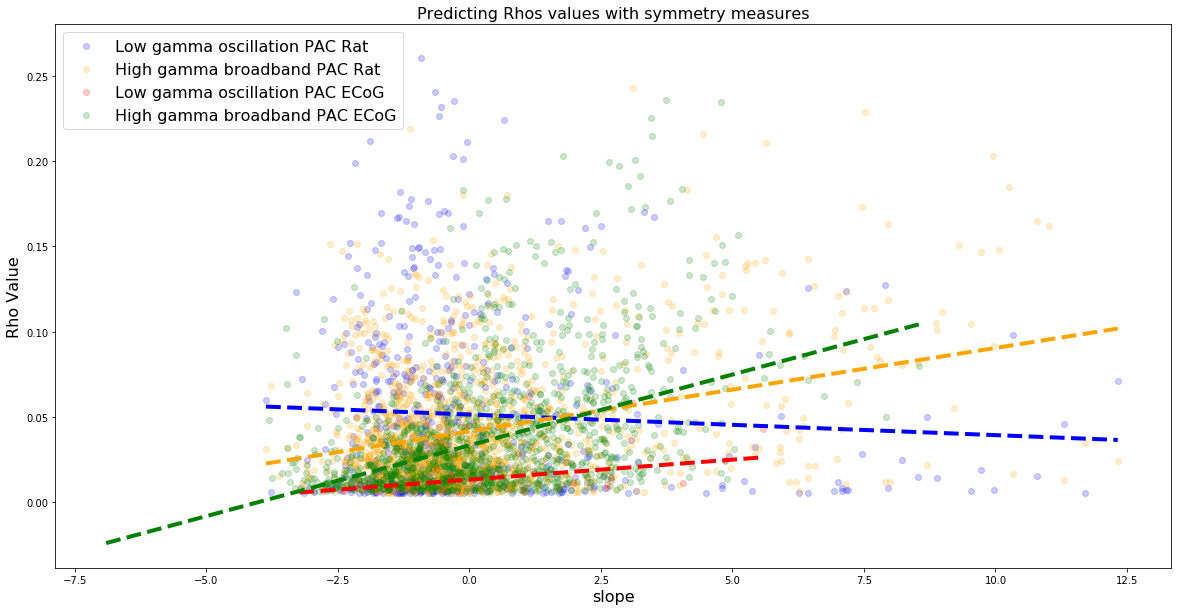

In [26]:
# reshape pac_rhos
LG_pac_rhos_rat = features_df['rat'][features_df['rat']['LG_pac_presence']==1]['LG_pac_rhos'].values.reshape(-1,1)
HG_pac_rhos_rat = features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'].values.reshape(-1,1)

LG_pac_rhos_ecog = np.append(features_df['monkey'][features_df['monkey']['LG_pac_presence']==1]['LG_pac_rhos'].values, 
         features_df['human'][features_df['human']['LG_pac_presence']==1]['LG_pac_rhos'].values).reshape(-1,1)
HG_pac_rhos_ecog = np.append(features_df['monkey'][features_df['monkey']['pac_presence']==1]['pac_rhos'].values, 
         features_df['human'][features_df['human']['pac_presence']==1]['pac_rhos'].values).reshape(-1,1)


"""
The features/columns: 

['subj', 'day', 'ch', 'ep', 'CF', 'Amp', 'BW', 'offset', 'knee', 'exp',
       'LG_CF', 'LG_Amp', 'LG_BW', 'pac_presence', 'pac_pvals', 'pac_rhos',
       'LG_pac_presence', 'LG_pac_pvals', 'LG_pac_rhos', 'volt_amp', 'rdsym',
       'ptsym', 'slope']
"""

feature = 'slope'

# reshape other feature
LG_feature_rat = features_df['rat'][features_df['rat']['LG_pac_presence']==1][feature].values.reshape(-1,1)
HG_feature_rat = features_df['rat'][features_df['rat']['pac_presence']==1][feature].values.reshape(-1,1)

LG_feature_ecog = np.append(features_df['monkey'][features_df['monkey']['LG_pac_presence']==1][feature].values,
                              features_df['human'][features_df['human']['LG_pac_presence']==1][feature].values).reshape(-1,1)
                              
HG_feature_ecog = np.append(features_df['monkey'][features_df['monkey']['pac_presence']==1][feature].values,
                              features_df['human'][features_df['human']['pac_presence']==1][feature].values).reshape(-1,1)

plt.figure(figsize=(20,10))

# Rat LG scatter
plt.scatter(features_df['rat'][features_df['rat']['LG_pac_presence']==1][feature],
            features_df['rat'][features_df['rat']['LG_pac_presence']==1]['LG_pac_rhos'],
           color='blue', alpha =.2, label='Low gamma oscillation PAC Rat')

# Rat HG scatter
plt.scatter(features_df['rat'][features_df['rat']['pac_presence']==1][feature],
            features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'],
           color='orange', alpha =.2, label='High gamma broadband PAC Rat')

# Monkey LG scatter
plt.scatter(features_df['monkey'][features_df['monkey']['LG_pac_presence']==1][feature],
            features_df['monkey'][features_df['monkey']['LG_pac_presence']==1]['LG_pac_rhos'],
           color='red', alpha =.2, label='Low gamma oscillation PAC ECoG')

# Monkey HG scatter
plt.scatter(features_df['monkey'][features_df['monkey']['pac_presence']==1][feature],
            features_df['monkey'][features_df['monkey']['pac_presence']==1]['pac_rhos'],
           color='green', alpha =.2, label='High gamma broadband PAC ECoG')


# Rat regression
reg1 = linear_model.LinearRegression()
reg1.fit(LG_feature_rat, LG_pac_rhos_rat)
xs = np.arange(min(LG_feature_rat), max(LG_feature_rat),0.01)
ys = reg1.intercept_[0] + reg1.coef_[0][0] * xs
plt.plot(xs, ys, '--', color='blue', linewidth=4, alpha=1)

# Rat regression
reg2 = linear_model.LinearRegression()
reg2.fit(HG_feature_rat, HG_pac_rhos_rat)
xs = np.arange(min(HG_feature_rat), max(HG_feature_rat),0.01)
ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
plt.plot(xs, ys, '--', color='orange', linewidth=4, alpha=1)

# monkey regression
reg3 = linear_model.LinearRegression()
reg3.fit(LG_feature_ecog, LG_pac_rhos_ecog)
xs = np.arange(min(LG_feature_ecog), max(LG_feature_ecog),0.01)
ys = reg3.intercept_[0] + reg3.coef_[0][0] * xs
plt.plot(xs, ys, '--', color='red', linewidth=4, alpha=1)

# monkey regression
reg4 = linear_model.LinearRegression()
reg4.fit(HG_feature_ecog, HG_pac_rhos_ecog)
xs = np.arange(min(HG_feature_ecog), max(HG_feature_ecog),0.01)
ys = reg4.intercept_[0] + reg4.coef_[0][0] * xs
plt.plot(xs, ys, '--', color='green', linewidth=4, alpha=1)


# 
plt.title('Predicting Rhos values with symmetry measures', fontsize=16)
plt.xlabel(feature, fontsize=16)
plt.ylabel('Rho Value', fontsize=16)
plt.legend(fontsize=16)
plt.show()